In [1]:
# upper half vs lower half
import numpy as np
import pandas as pd
from scipy.io import loadmat
import glob
import os
import sys
import matplotlib.pyplot as plt
from pingouin import pairwise_corr
import seaborn as sns
sns.set(style="white")

from scipy import stats
from mne.viz import circular_layout, plot_connectivity_circle
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

import scipy.stats as chi2_contingency
import scipy.stats as stats
from scipy.spatial import distance

from matplotlib import cm

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
import math

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import pymc3 as pm
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

# increasing display number of pandas columns and rows
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

/Users/anna/anaconda3/lib/python3.7/site-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [2]:
# functions to transform vector to dfnc matrix
def calc_num_components(a):
    num_pairs = len(a)
    num_components = int(np.ceil(np.sqrt(2 * num_pairs - 1)))
    if num_components * (num_components - 1) == 2 * num_pairs:
        return num_components
    else:
        return 0


def return_dfnc_from_vector(a):
    '''This Function returns a dfnc matrix given a vector
        a : the vector of correlation pairs
    '''
    n = calc_num_components(a)
    out = np.zeros((n, n))

    if not n:
        return out
    
    l_indices = np.tril_indices(n, -1)
    u_indices = np.triu_indices(n, 1)

    out[u_indices] = a
    out[l_indices] = out.T[l_indices]
    
    return out

In [3]:
# Load clinical variables of stroke patients
Salvo = pd.read_csv("/.../DFNC/Behavior/SALVO_1206.csv")

n_subjects = 41
# Number of dFNC windows, number of correlations
n_windows = 129
n_corr = 1176

# Defining subgroups of vairably affected patients
mild = Salvo.InHospitalNIHSS.sort_values()[0:19].index
moderate = Salvo.InHospitalNIHSS.sort_values()[19:34].index
severe = Salvo.InHospitalNIHSS.sort_values()[34:41].index

# load subject names
subject_names = glob.glob('/..../WithSM_dfnc_sub*',)
subject_names = sorted(subject_names)
# checked subject order

# load dwell times  (as saved after dFNC computation in matlab)

dwell = loadmat('/.../dwell_time.mat')["dwell"]
dwell = pd.DataFrame(dwell)
dwell.columns = ["State_1", "State_2", "State_3"]


In [28]:
with pm.Model() as hierarchical_linear_model_2:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=10)
    sigma_a = pm.HalfCauchy('sigma_a',5)

    
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_studies)
    b = pm.Normal('b', mu=0, sd=10)
    #b1 = pm.Normal('b1', mu=0, sd=10)
    b2 = pm.Normal('b2', mu=0, sd=10)
    b3 = pm.Normal('b3', mu=0, sd=10)
    b4 = pm.Normal('b4', mu=0, sd=10)
    b5 = pm.Normal('b5', mu=0, sd=1)
    b6 = pm.Normal('b6', mu=0, sd=10)
    b7 = pm.Normal('b7', mu=0, sd=1)
    
    # Model error
    eps = pm.HalfCauchy('eps', 10)

    NIHSS_est = a[study_idx] + b * Salvo_merged.FirstNIHSS + b2 * Salvo_merged.Dwell_1 + b3 * Salvo_merged.Dwell_2 + b4 * Salvo_merged.Dwell_3 + b5 * Salvo_merged.IVtPA1 + b6 * Salvo_merged.Age + b7 * Salvo_merged.Sex

    # Data likelihood
    NIHSS_like = pm.Normal('NIHSS_like', mu=NIHSS_est, sd=eps, observed=Salvo_merged.InHospitalNIHSS)


with hierarchical_linear_model_2:
    hierarchical_linear_trace_2 = pm.sample(draws=2000, n_init=1000, random_seed=12345,chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, b7, b6, b5, b4, b3, b2, b, a, sigma_a, mu_a]
Sampling chain 0, 102 divergences: 100%|██████████| 2500/2500 [00:20<00:00, 124.51it/s]
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


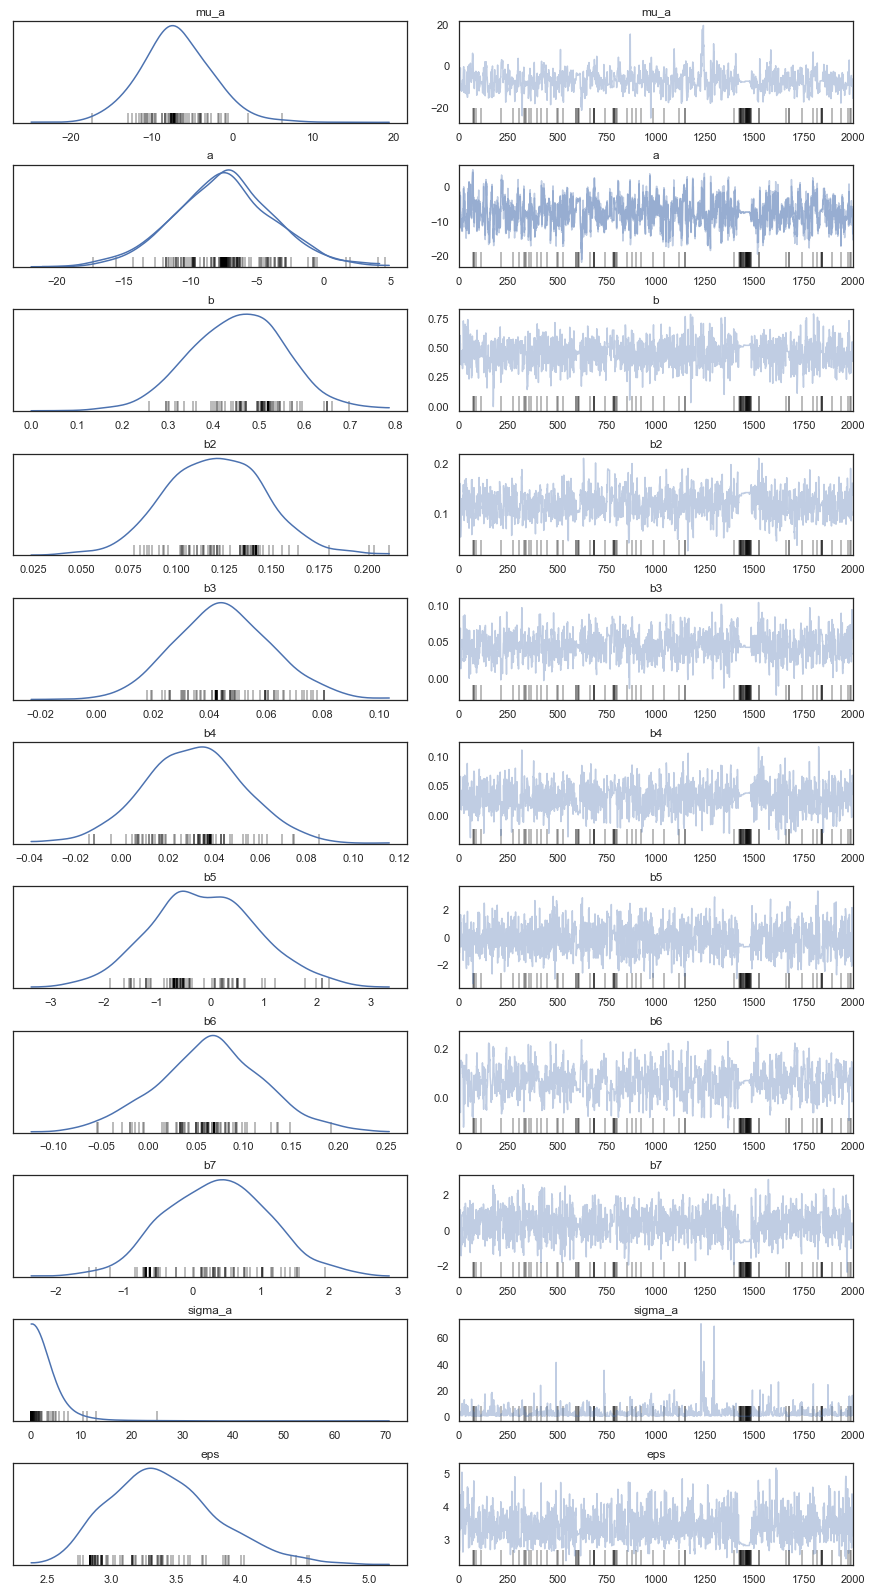

In [29]:
pm.traceplot(hierarchical_linear_trace_2)
plt.show()

In [33]:
pm.summary(hierarchical_linear_trace_2)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,-6.960,4.490,-15.653,0.814,0.230,0.163,380.0,380.0,412.0,514.0,NaN
a[0],-7.477,3.652,-14.348,-0.449,0.169,0.120,467.0,467.0,469.0,723.0,NaN
a[1],-7.618,3.848,-14.919,-0.483,0.179,0.127,463.0,463.0,464.0,717.0,NaN
b,0.452,0.107,0.258,0.655,0.004,0.003,887.0,878.0,902.0,705.0,NaN
b2,0.120,0.026,0.073,0.169,0.001,0.001,588.0,570.0,608.0,622.0,NaN
b3,0.045,0.017,0.012,0.077,0.001,0.000,660.0,601.0,666.0,679.0,NaN
b4,0.031,0.022,-0.010,0.073,0.001,0.001,813.0,813.0,807.0,980.0,NaN
b5,-0.116,1.027,-2.037,1.837,0.032,0.030,1054.0,579.0,1060.0,1001.0,NaN
b6,0.065,0.056,-0.054,0.164,0.002,0.002,530.0,530.0,529.0,841.0,NaN
b7,0.352,0.764,-1.070,1.780,0.037,0.026,431.0,431.0,415.0,1092.0,NaN


In [30]:
Y_ppc_insample = pm.sample_ppc(hierarchical_linear_trace_2, 2000, hierarchical_linear_model_2, random_seed=456)['NIHSS_like']
y_pred_insample = Y_ppc_insample.mean(axis=0)
ppc_insample = r2_score(Salvo_merged.InHospitalNIHSS.values, y_pred_insample)
out_str = 'PPC in sample R^2: %2.6f' % (ppc_insample)
print(out_str)


/Users/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 2000/2000 [00:02<00:00, 953.79it/s] 

PPC in sample R^2: 0.648548


In [31]:
df_comp_WAIC = pm.compare({hierarchical_linear_model_NIHSS: hierarchical_linear_trace_NIHSS, hierarchical_linear_model_2: hierarchical_linear_trace_2,}, ic='LOO' )
df_comp_WAIC

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
<pymc3.model.Model object at 0x1c31687710>,0,223.995,6.69999,0,0.946359,10.7686,0,False,deviance
<pymc3.model.Model object at 0x115238940>,1,238.989,4.68332,14.9932,0.0536411,6.82257,9.85252,False,deviance


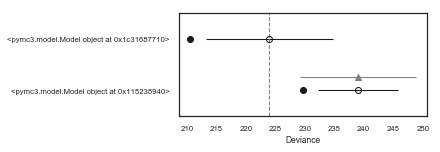

In [32]:
pm.compareplot(df_comp_WAIC)

/Users/anna/anaconda3/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:226: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  warnings.warn('constrained_layout not applied.  At least '
/Users/anna/anaconda3/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:226: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  warnings.warn('constrained_layout not applied.  At least '
/Users/anna/anaconda3/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:226: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  warnings.warn('constrained_layout not applied.  At least '
/Users/anna/anaconda3/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:226: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  warnings.warn('constrained_layout not applied.  At least '
/Use

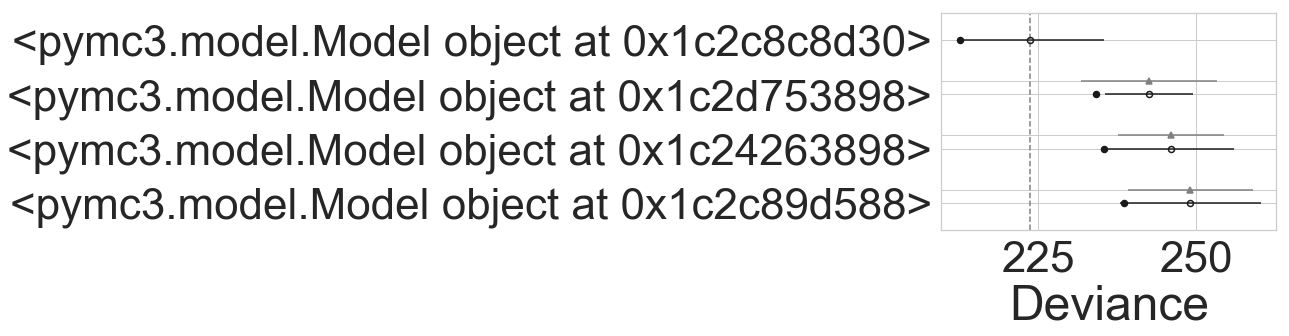

In [168]:
pm.compareplot(df_comp_WAIC)

In [169]:
pm.loo(hierarchical_linear_trace_Dwell, hierarchical_linear_model_Dwell)

/Users/anna/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 2000 by 41 log-likelihood matrix

       Estimate       SE
IC_loo   246.21    10.20
p_loo      5.38        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       38   92.7%
 (0.5, 0.7]   (ok)          2    4.9%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    1    2.4%

In [170]:
pm.loo(hierarchical_linear_trace_NIHSS, hierarchical_linear_model_NIHSS)

Computed from 5000 by 41 log-likelihood matrix

       Estimate       SE
IC_loo   242.73    11.89
p_loo      4.32        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       40   97.6%
 (0.5, 0.7]   (ok)          1    2.4%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [171]:
pm.loo(hierarchical_linear_trace_Fraction, hierarchical_linear_model_Fraction)

Computed from 2000 by 41 log-likelihood matrix

       Estimate       SE
IC_loo   249.00    10.94
p_loo      5.25        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       41  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [172]:
pm.loo(hierarchical_linear_trace_2, hierarchical_linear_model_2)

Computed from 2000 by 41 log-likelihood matrix

       Estimate       SE
IC_loo   224.13     7.01
p_loo      5.73        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       38   92.7%
 (0.5, 0.7]   (ok)          3    7.3%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%